In [4]:
#!pip install fedot

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "10"
os.environ["NUMEXPR_NUM_THREADS"] = "10"
os.environ["OMP_NUM_THREADS"] = "10"

import torch
torch.set_num_threads(10)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.raiseExceptions = False

import fedot
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
import inspect

In [6]:
from google.colab import files
uploaded = files.upload()

Saving ts study 1.txt to ts study 1.txt


In [21]:
ts_tabular =pd.read_csv('ts study 1.txt')
ts_real_temp = ts_tabular[ts_tabular['label']=='temp'].drop('label',axis=1)['value'].to_numpy()
ts_real_traffic = ts_tabular[ts_tabular['label']=='traffic_volume'].drop('label',axis=1)['value'].to_numpy()

In [8]:
def s1(n,noise = 3,sign=1):
    def f1(x):
        return 5*np.sin(x/20)+0.1*x-2*np.sqrt(x)
    trend = f1(np.array(range(n)))
    noise = np.random.normal(loc = 0, scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend' : trend*sign}
    return ans
def s2(length, periods = 10,noise = 0.3,sign=1 ):

    sinusoidal_data = np.linspace(-periods * np.pi, periods * np.pi, length)
    sinusoidal_data = np.sin(sinusoidal_data)
    cos_1_data = np.linspace(-periods * np.pi/2, periods/2 * np.pi/2, int(length/2))
    cos_1_data = np.cos(cos_1_data) 
    cos_2_data = np.linspace(periods/2 * np.pi/2, periods * np.pi/2, int(length/2))
    cos_2_data = np.cos(cos_2_data)   
    cosine_data = np.hstack((cos_1_data, cos_2_data))
    
    random_noise = np.random.normal(loc=0.0, scale=noise, size=length)
    synthetic_data = sinusoidal_data + cosine_data + random_noise
    ans = {'ts':synthetic_data*sign, 'trend': (sinusoidal_data + cosine_data)*sign}
    return ans
def s3(n,noise = 10,sign = 1):
    r = np.array(range(n))
    trend = (r-r/5*np.sin(r/2)+r/2*np.sin(r/20))/10
    noise = np.random.normal(loc=0,scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend': trend*sign}
    return ans
def s4(n,noise = 1,sign =1):
    array = np.array(range(n))
    trend = array/5+np.power(array,0.5)*np.sin(np.pi/12*array)
    noise = np.random.normal(loc = 0,scale = noise, size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign, 'trend' : trend*sign}
    return ans

def s5(n,noise = 1,sign=1):
    r= np.arange(n)
    trend = r*1
    noise = np.random.normal(loc=0,scale = noise,size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign,'trend':trend*sign}
    return ans

def s6(n,noise = 1, sign =1):
    r = np.arange(n)
    trend = 2*np.sin(2*r)+np.cos(r)
    noise = np.random.normal(loc = 0,scale  = noise,size = n)
    ts = trend+noise
    ans = {'ts':ts,'trend':trend}
    return ans

In [22]:
horizon = 30
validation_blocks = 2
task = Task(TaskTypesEnum.ts_forecasting,  TsForecastingParams(forecast_length=horizon))
start = 0
end = 1000
series = 'traffic'

if series == 'traffic':
  init_series = ts_real_traffic
  ts = init_series[start:end]
  trend = None
  ts_test = init_series[end:end+horizon]
  trend_test = None

if series == 'temp':
    init_series = ts_real_temp
    ts = init_series[start:end]
    trend = None
    ts_test = init_series[end:end+horizon]
    trend_test = None

if series ==1:
    noise = 0.5
    init_series = s1(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]  
    
if series ==2:
    noise = 0.5
    init_series = s2(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==3:
    noise = 0.5
    init_series = s3(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==4:
    noise = 0.5
    init_series = s4(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
  
if series ==5:
    noise = 1
    init_series = s5(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]   

if series ==6:
    noise = 0.5
    init_series = s6(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
 
idx = np.array( range(len(np.array(ts))) )
train_input = InputData(idx=idx,
                            features=ts,
                            target=ts,
                            task=task,
                            data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input, validation_blocks=2)

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting',
                  safe_mode = True,
                  task_params=task.task_params,
                  timeout=3,
                  n_jobs=-1,
                  cv_folds=2, 
                  validation_blocks=2, 
                  preset='ts',
                  with_tuning = False,
                  max_depth = 5,
                  num_of_generations  =3 ,
                  logging_level = 10,
                 show_progress =True)

In [46]:
#inspect.getmembers(model)

INFO:root:AssumptionsHandler - Initial pipeline fitting started


2022-11-24 18:02:43,920 - AssumptionsHandler - Initial pipeline fitting started


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 18:02:43,928 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:02:43,934 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 18:02:43,941 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:02:43,944 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: lagged


2022-11-24 18:02:43,947 - PrimaryNode - Trying to fit primary node with operation: lagged


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: glm


2022-11-24 18:02:44,055 - PrimaryNode - Trying to fit primary node with operation: glm


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:02:44,127 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:02:44,133 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:02:44,140 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:02:44,143 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 18:02:44,146 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 18:02:44,151 - PrimaryNode - Predict in primary node by operation: glm


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2022-11-24 18:02:44,158 - AssumptionsHandler - Initial pipeline was fitted successfully


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 0.2 sec.


2022-11-24 18:02:44,163 - ApiComposer - Initial pipeline was fitted in 0.2 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['pca', 'dtreg', 'gaussian_filter', 'stl_arima', 'ets', 'arima', 'ts_naive_average', 'smoothing', 'glm', 'cut', 'ar', 'fast_ica', 'normalization', 'linear', 'scaling', 'lasso', 'locf', 'ridge', 'polyfit', 'sgdr', 'sparse_lagged', 'diff_filter', 'adareg', 'lagged']


2022-11-24 18:02:44,187 - ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['pca', 'dtreg', 'gaussian_filter', 'stl_arima', 'ets', 'arima', 'ts_naive_average', 'smoothing', 'glm', 'cut', 'ar', 'fast_ica', 'normalization', 'linear', 'scaling', 'lasso', 'locf', 'ridge', 'polyfit', 'sgdr', 'sparse_lagged', 'diff_filter', 'adareg', 'lagged']


CRITICAL:root:ApiComposer - Pipeline composition started.


2022-11-24 18:02:44,229 - ApiComposer - Pipeline composition started.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2022-11-24 18:02:44,232 - DataSourceSplitter - K-folds cross validation is applied.


Generations:  33%|███▎      | 1/3 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:02:44,238 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 1


2022-11-24 18:02:44,856 - EvoGraphOptimizer - Generation num: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1315.6506741704295, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 18:02:44,863 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1315.6506741704295, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 18:02:44,866 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.0 min


2022-11-24 18:02:44,869 - EvoGraphOptimizer - spent time: 0.0 min


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:02:46,343 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 2


2022-11-24 18:02:58,251 - EvoGraphOptimizer - Generation num: 2


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 929.7424880197698, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.7}]


2022-11-24 18:02:58,257 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 929.7424880197698, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.7}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 18:02:58,261 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.2 min


2022-11-24 18:02:58,265 - EvoGraphOptimizer - spent time: 0.2 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 5


2022-11-24 18:02:58,268 - EvoGraphOptimizer - Next population size: 34; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:02:59,075 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 3


2022-11-24 18:03:11,822 - EvoGraphOptimizer - Generation num: 3


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 929.7424880197698, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.7}]


2022-11-24 18:03:11,833 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 929.7424880197698, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.7}]


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2022-11-24 18:03:11,838 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2022-11-24 18:03:11,842 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 5


2022-11-24 18:03:11,846 - EvoGraphOptimizer - Next population size: 55; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:03:13,081 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 4


2022-11-24 18:03:29,860 - EvoGraphOptimizer - Generation num: 4


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 929.7424880197698, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.7}]


2022-11-24 18:03:29,873 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 929.7424880197698, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.7}]


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2022-11-24 18:03:29,877 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.8 min


2022-11-24 18:03:29,882 - EvoGraphOptimizer - spent time: 0.8 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2022-11-24 18:03:29,887 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:  33%|███▎      | 1/3 [00:45<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 0.761 min


2022-11-24 18:03:29,894 - OptimisationTimer - Composition time: 0.761 min


INFO:root:GPComposer - GP composition finished


2022-11-24 18:03:29,909 - GPComposer - GP composition finished


CRITICAL:root:ApiComposer - Model generation finished


2022-11-24 18:03:30,364 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2022-11-24 18:03:31,050 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 6, 'length': 7, 'nodes': [dtreg, ridge, glm, ridge, lagged, linear, decompose]}


2022-11-24 18:03:31,062 - FEDOT logger - Final pipeline: {'depth': 6, 'length': 7, 'nodes': [dtreg, ridge, glm, ridge, lagged, linear, decompose]}


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: dtreg


2022-11-24 18:03:31,074 - SecondaryNode - Obtain prediction in secondary node with operation: dtreg


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: dtreg


2022-11-24 18:03:31,080 - SecondaryNode - Fit all parent nodes in secondary node with operation: dtreg


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: linear


2022-11-24 18:03:31,088 - SecondaryNode - Obtain prediction in secondary node with operation: linear


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: linear


2022-11-24 18:03:31,092 - SecondaryNode - Fit all parent nodes in secondary node with operation: linear


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: decompose


2022-11-24 18:03:31,095 - SecondaryNode - Obtain prediction in secondary node with operation: decompose


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: decompose


2022-11-24 18:03:31,101 - SecondaryNode - Fit all parent nodes in secondary node with operation: decompose


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:03:31,106 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:03:31,113 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:03:31,116 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:03:31,119 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 18:03:31,124 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 18:03:31,129 - PrimaryNode - Predict in primary node by operation: glm


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 18:03:31,135 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:03:31,141 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:03:31,150 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:03:31,154 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:03:31,157 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 18:03:31,161 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 18:03:31,166 - PrimaryNode - Predict in primary node by operation: glm


2022-11-24 18:03:31,239 - OperationTypesRepository - Operation lagged not found in the repository


2022-11-24 18:03:31,243 - OperationTypesRepository - Operation decompose not found in the repository


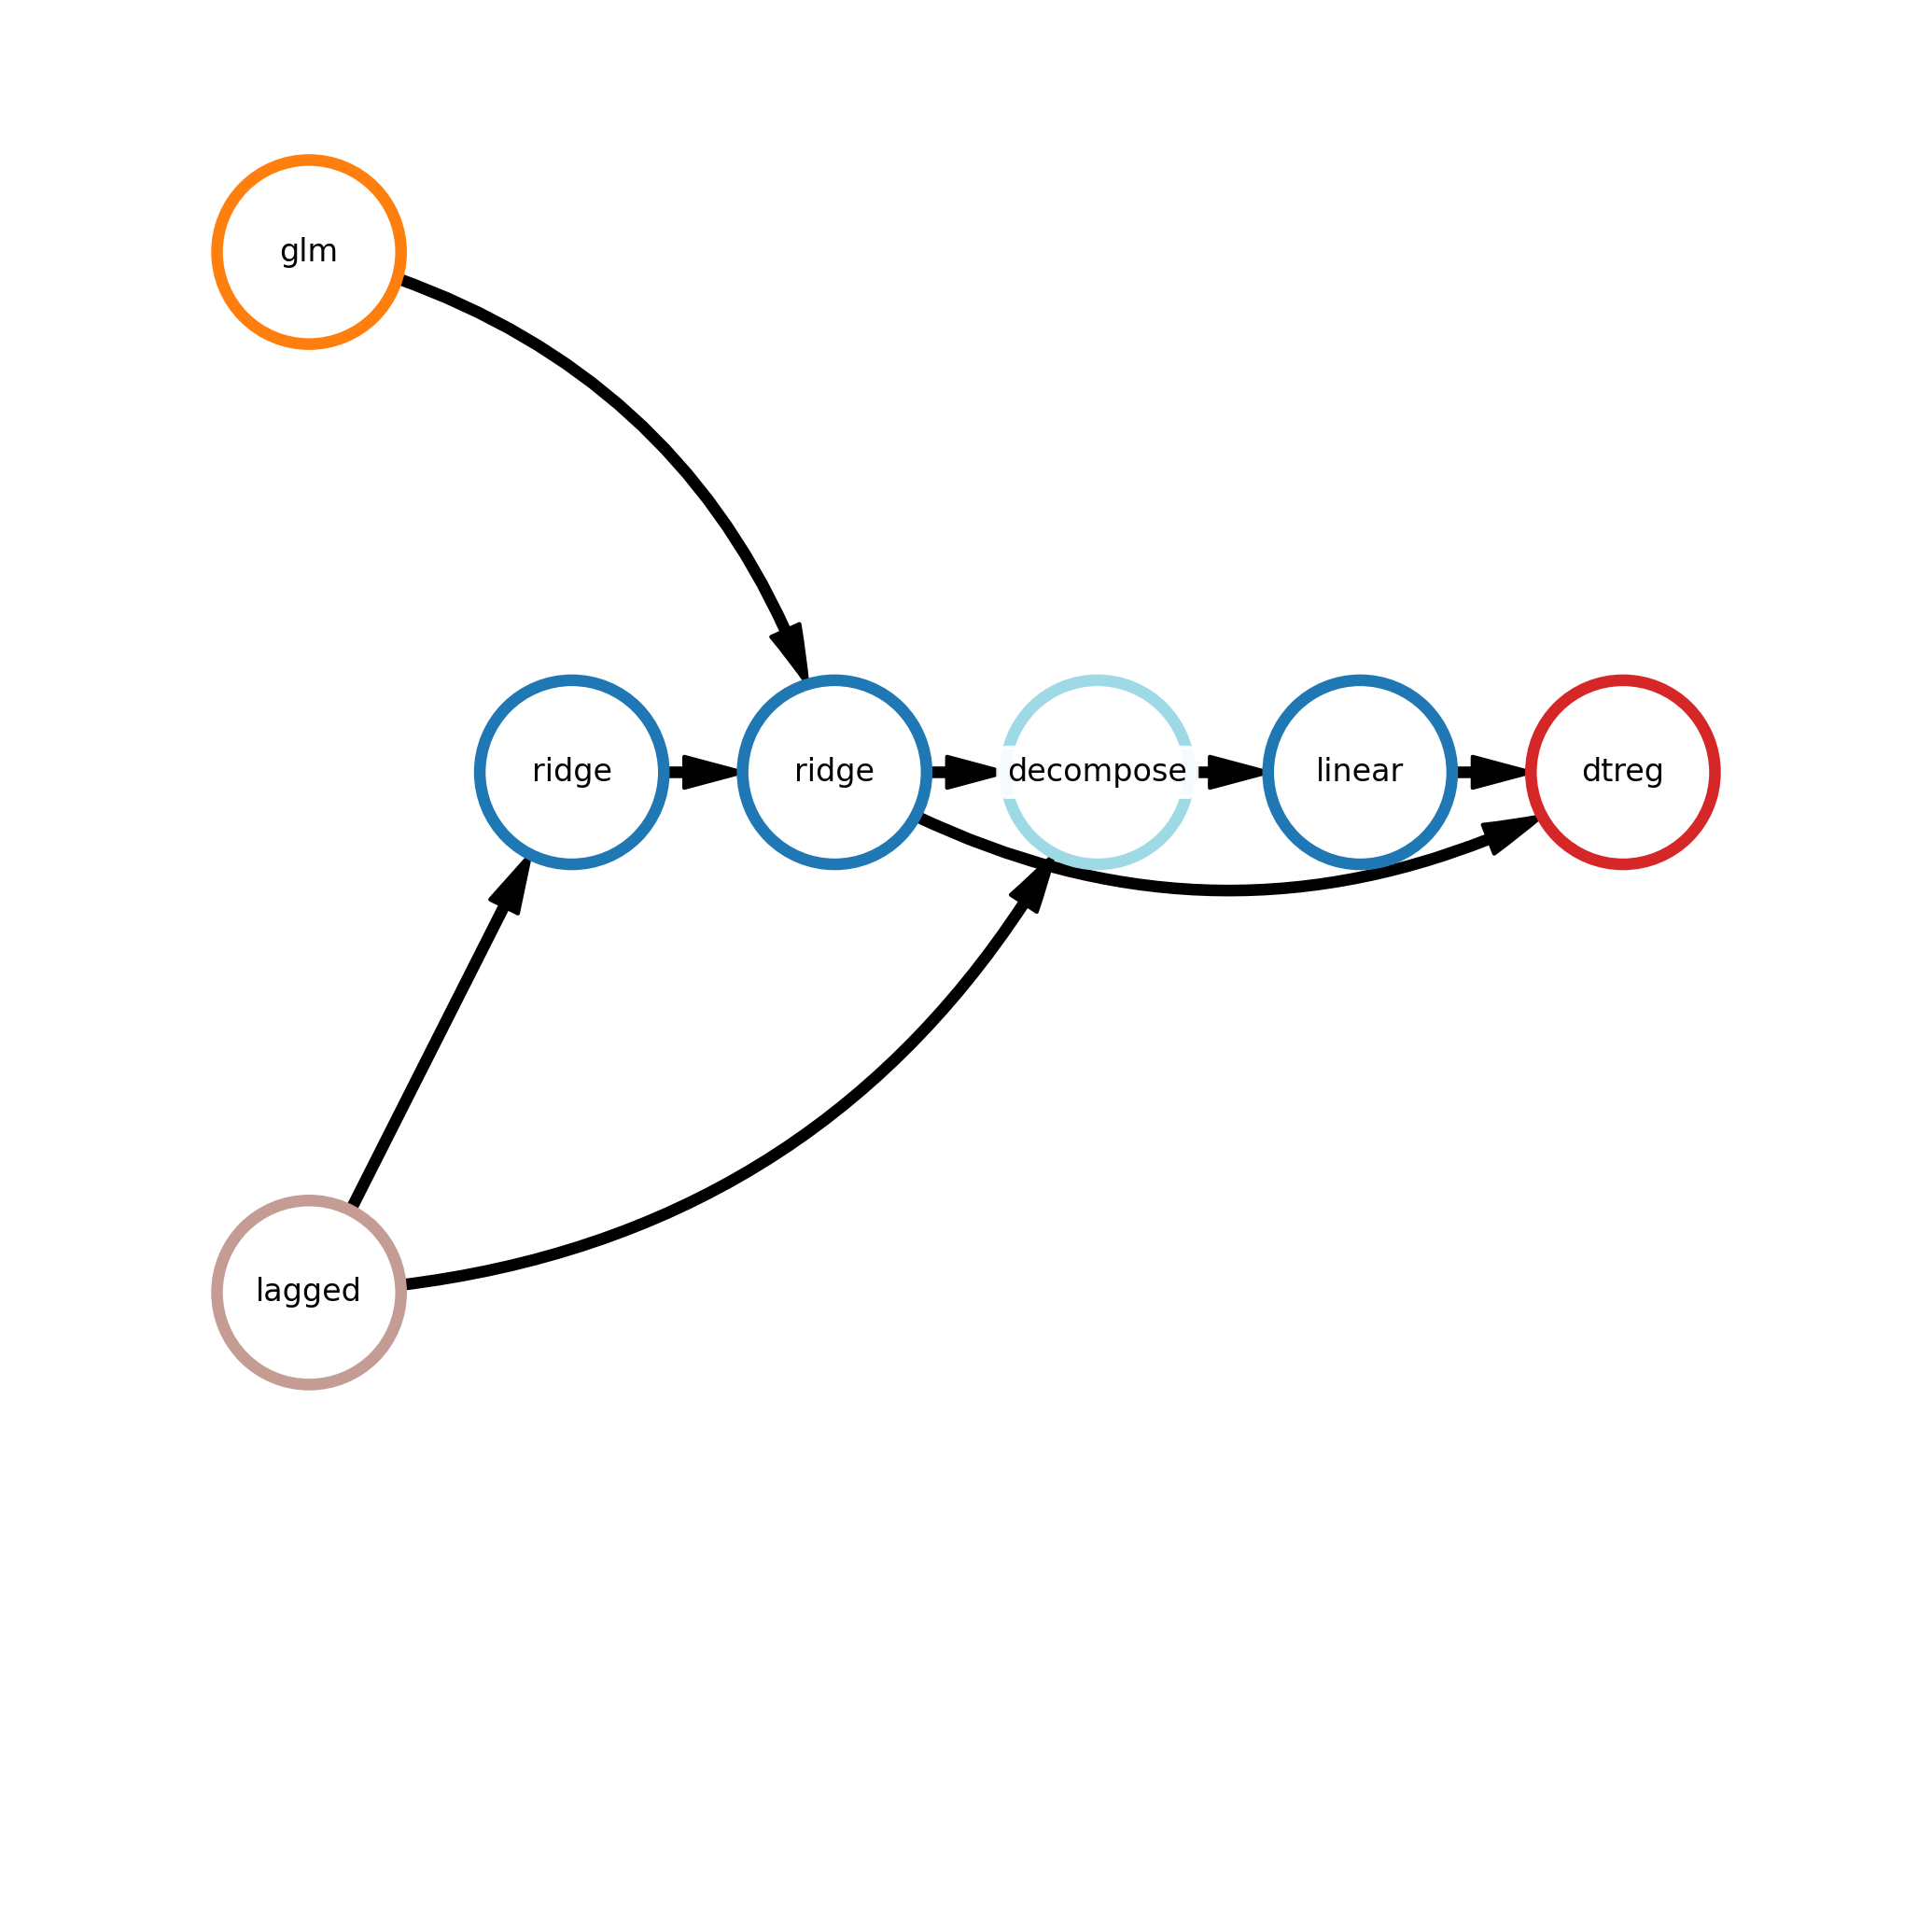

In [25]:
pipeline = model.fit(train_data)
forecast = model.forecast(test_data)
pipeline.show()

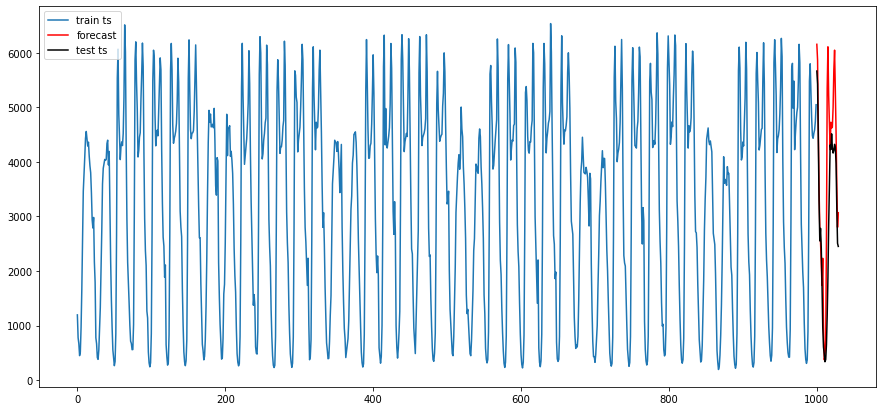

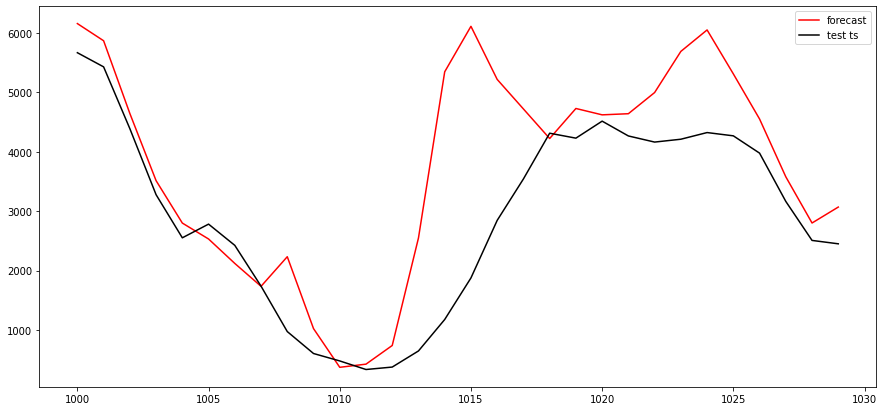

In [26]:
fig,ax  = plt.subplots()
fig.set(figwidth = 15,figheight = 7)
test_range = range(len(ts), len(ts)+len(ts_test))
test_range = range(end,end+horizon)
train_range = range(start,end)
total_range = range(start,end+horizon)

ax.plot(train_range,ts, label = 'train ts')
if trend is not None:
    ax.plot(train_range, trend,color = 'green',label = 'trend')
if trend_test is not None:
    ax.plot(test_range, trend_test,color = 'green')
ax.plot(test_range,forecast, color = 'red', label = 'forecast')
ax.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

fig1,ax1 = plt.subplots()
fig1.set(figwidth = 15,figheight = 7)

if trend_test is not None:
    ax1.plot(test_range, trend_test,color = 'green')
ax1.plot(test_range,forecast, color = 'red', label = 'forecast')
ax1.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

In [27]:
import sys
from sklearn.metrics import mean_squared_error as mse
from fedot.core.composer.metrics import QualityMetric
from fedot.core.data.data import InputData, OutputData
from fedot.core.repository.tasks import TsForecastingParams

def quantile_loss(y_true, y_pred, quantile=0.5):
    res = np.array(y_true)-np.array(y_pred)
    metrics=np.empty(shape = [0])
    for x in res:
        if x>=0:
            metrics = np.append(metrics, quantile*x)
        else:
            metrics = np.append(metrics,(quantile-1)*x)
    return np.mean(metrics)

class Quantile_Loss_1(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.1)
        return value


class Quantile_Loss_9(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.9)
        return value

In [28]:
#importing for tuning
from fedot.core.optimisers.adapters import PipelineAdapter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.pipelines.tuning.tuner_interface import HyperoptTuner
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.optimisers.composer_requirements import ComposerRequirements
import datetime

from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

#these parameters are the same for both tuners below
task = Task(TaskTypesEnum.ts_forecasting,TsForecastingParams(forecast_length=horizon))
composer_requirements = ComposerRequirements()
composer_requirements.validation_blocks = 2
composer_requirements.n_jobs= -1
composer_requirements.show_progress = True

#this tuner will be used to create lower confidence interval
low_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_1.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

#this tuner will be used to create uppper confidence interval
up_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_9.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 18:04:25,080 - DataSourceSplitter - Hold out validation is applied.


INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 18:04:25,091 - DataSourceSplitter - Hold out validation is applied.


In [29]:
def quantile_maker(quantile,arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    up = []
    low = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        q_up = np.quantile(x, 1-quantile)
        up.append(q_up)
        q_low = np.quantile(x,quantile)
        low.append(q_low)
    up = np.array(up)
    low = np.array(low)
    return {'up':up,'low':low}

def mean_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    average = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        average.append(x.mean())
    return average

def median_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    median = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        median.append(np.median(x))
    return median

def absolute_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    maximum = []
    minimum = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        maximum.append(np.max(x))
        minimum.append(np.min(x))
    return {'up':np.array(maximum),'low':np.array(minimum)}

from scipy.stats import trim_mean
def truncated_mean_maker(arrays, quantile=0.1):
    number_arrays = len(arrays)
    l = len(arrays[0])
    trunc_mean = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        trunc_mean.append(trim_mean(x, quantile))
    return np.array(trunc_mean)

In [30]:
def conf_int_maker(model = model,
                   train_ts = ts,
                   number_models = 10, 
                   pipelines_show= False):
    """
    model - a fedot model of interest
    train_ts - the ts used for training the model
    ts_test - the testing series; used for plotting and visualization of the results
    number_models - number of models used to create the confidence intervals
    regim - type of getting lower and upper confidence intervals from the upper and lower arrays; 
            default is 'quantile' also avaliable 'average' and 'median', 'absolute_bounds', 'truncated_mean'
    plot - boolean parameter indicating wheter to show plot of the forecast and confidence intervals
    plot_history - boolean parameter indicating whether to show previous series
    """
    
    horizon = model.params.task.task_params.forecast_length
    train_data = model.train_data
    test_data = model.test_data
    forecast = model.predict(test_data)

    #4 lines below allow us take the best models
    fits = []
    for ind in model.history.individuals[-1]:
        fits.append(ind.fitness.value)
    fits = np.sort(np.array(fits))

    #create up and low predictions
    up_predictions = []
    low_predictions = []
    
    s=1
    for ind in model.history.individuals[-1]:
        if ind.fitness.value<=fits[number_models]:
            pipeline = PipelineAdapter().restore(ind.graph)
            print(f'Fitting pipeline №{s}')
            s+=1
            if pipelines_show:
                pipeline.show()
            
            
            #tuning upper confidence interval
            tuned_pipeline = up_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            up_predictions.append(preds)
            del tuned_pipeline
            
            #tuning lower confidence interval
            tuned_pipeline = low_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            low_predictions.append(preds)
            del tuned_pipeline
    return {'up_predictions':up_predictions, 'low_predictions':low_predictions}

In [31]:
def conf_int_plotting(up_predictions,
                      low_predictions,
                      horizon=horizon,
                      forecast=forecast,
                      ts=ts,
                      ts_test=ts_test,
                      trend_test=trend_test,
                      regim = 'quantile',
                      plot_history = True,
                      plot_up_int = True,
                      plot_low_int = True,
                      plot_trend = True,
                      plot_forecast = True,
                      plot_upper_train = True,
                      plot_lower_train = True,
                      plot_ts_test = True):
    if regim == 'quantile':
        up_res= quantile_maker(quantile = 0.1, arrays = up_predictions)['up']
        low_res= quantile_maker(quantile = 0.1, arrays = low_predictions)['low']
    if regim == 'mean':
        up_res = mean_maker(arrays = up_predictions)
        low_res = mean_maker(arrays = low_predictions)
    if regim == 'median':
        up_res = median_maker(arrays = up_predictions)
        low_res = median_maker(arrays = low_predictions)
    if regim == 'absolute_bounds':
        up_res = absolute_maker(arrays = up_predictions)['up']
        low_res = absolute_maker(arrays = low_predictions)['low']
    if regim == 'truncated_mean':
        up_res = truncated_mean_maker(arrays = up_predictions)
        low_res = truncated_mean_maker(arrays = low_predictions)
    
    up = np.maximum(up_res,forecast)  
    low = np.minimum(low_res,forecast)

    r = range(1,horizon+1)
    fig,ax = plt.subplots()
    fig.set(figwidth = 15,figheight = 7)
    for i in range(len(up_predictions)):
        if i==0:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow',label = 'preds for up train')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink',label = 'preds for low train')
        else:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink')    
    if plot_up_int:
        ax.plot(r,up, color = 'blue', label  = 'Up',marker= '.')
    if plot_low_int:
        ax.plot(r,low, color = 'green', label  = 'Low',marker = '.')
    if plot_forecast:
        ax.plot(r,forecast, color = 'red', label = 'Forecast')
    if ts_test is not None:
        if plot_ts_test:
            ax.plot(r,ts_test,color = 'black', label = 'Actual TS')
    if trend_test is not None:
        if plot_trend:
            ax.plot(r, trend_test, color = 'magenta', label = 'True Trend')
    plt.legend()
    if plot_history:
        fig1,ax1 = plt.subplots()
        
        fig1.set(figwidth = 15,figheight = 7)
       
        train_range = range(len(ts))
        test_range = range(len(ts),len(ts)+horizon)
        
        ax1.plot(train_range,ts, color = 'gray',label = 'Train ts')
        ax1.plot(test_range, up,color = 'blue', label = 'Up')
        ax1.plot(test_range, low,color = 'green', label = 'Low')
        ax1.plot(test_range,forecast, color = 'red', label = 'Forecast')
        if ts_test is not None:
            ax1.plot(test_range, ts_test,color = 'black', label = 'Actual TS')  
        if trend_test is not None:
            ax1.plot(test_range, trend_test, color = 'magenta', label = 'True Trend')
        plt.legend();

In [32]:
x = conf_int_maker(model = model, number_models =7,pipelines_show = False)

INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №1
2022-11-24 18:04:32,867 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007689 seconds


2022-11-24 18:04:33,550 - build_posterior_wrapper took 0.007689 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:04:33,557 - TPE using 0 trials
 10%|█         | 1/10 [00:05<00:46,  5.22s/trial, best loss: 815.582587632275]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012989 seconds


2022-11-24 18:04:38,778 - build_posterior_wrapper took 0.012989 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 815.582588


2022-11-24 18:04:38,789 - TPE using 1/1 trials with best loss 815.582588
 20%|██        | 2/10 [00:12<00:51,  6.48s/trial, best loss: 213.52183333333332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008832 seconds


2022-11-24 18:04:46,131 - build_posterior_wrapper took 0.008832 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 213.521833


2022-11-24 18:04:46,140 - TPE using 2/2 trials with best loss 213.521833
 30%|███       | 3/10 [00:19<00:46,  6.62s/trial, best loss: 213.52183333333332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008792 seconds


2022-11-24 18:04:52,929 - build_posterior_wrapper took 0.008792 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 213.521833


2022-11-24 18:04:52,939 - TPE using 3/3 trials with best loss 213.521833
 40%|████      | 4/10 [00:24<00:35,  5.85s/trial, best loss: 213.52183333333332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008569 seconds


2022-11-24 18:04:57,594 - build_posterior_wrapper took 0.008569 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 213.521833


2022-11-24 18:04:57,610 - TPE using 4/4 trials with best loss 213.521833
 50%|█████     | 5/10 [00:31<00:31,  6.30s/trial, best loss: 213.52183333333332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009990 seconds


2022-11-24 18:05:04,697 - build_posterior_wrapper took 0.009990 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 213.521833


2022-11-24 18:05:04,704 - TPE using 5/5 trials with best loss 213.521833
 60%|██████    | 6/10 [00:31<00:17,  4.44s/trial, best loss: 213.52183333333332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008080 seconds


2022-11-24 18:05:05,529 - build_posterior_wrapper took 0.008080 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 213.521833


2022-11-24 18:05:05,541 - TPE using 6/6 trials with best loss 213.521833
 70%|███████   | 7/10 [00:35<00:12,  4.03s/trial, best loss: 213.52183333333332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014194 seconds


2022-11-24 18:05:08,727 - build_posterior_wrapper took 0.014194 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 213.521833


2022-11-24 18:05:08,738 - TPE using 7/7 trials with best loss 213.521833
 80%|████████  | 8/10 [00:37<00:07,  3.54s/trial, best loss: 213.52183333333332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010995 seconds


2022-11-24 18:05:11,212 - build_posterior_wrapper took 0.010995 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 213.521833


2022-11-24 18:05:11,224 - TPE using 8/8 trials with best loss 213.521833
 90%|█████████ | 9/10 [00:38<00:02,  2.76s/trial, best loss: 159.75390056022414]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009817 seconds


2022-11-24 18:05:12,249 - build_posterior_wrapper took 0.009817 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 159.753901


2022-11-24 18:05:12,267 - TPE using 9/9 trials with best loss 159.753901
100%|██████████| 10/10 [00:43<00:00,  4.34s/trial, best loss: 159.75390056022414]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:05:18,016 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 159.754 equal or better than initial (+ 5% deviation) 197.544


2022-11-24 18:05:18,034 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 159.754 equal or better than initial (+ 5% deviation) 197.544


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:05:18,970 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010963 seconds


2022-11-24 18:05:20,818 - build_posterior_wrapper took 0.010963 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:05:20,824 - TPE using 0 trials
 10%|█         | 1/10 [00:06<00:55,  6.13s/trial, best loss: 219.08800168504908]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.020696 seconds


2022-11-24 18:05:26,962 - build_posterior_wrapper took 0.020696 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 219.088002


2022-11-24 18:05:26,969 - TPE using 1/1 trials with best loss 219.088002
 20%|██        | 2/10 [00:12<00:48,  6.09s/trial, best loss: 219.08800168504908]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010098 seconds


2022-11-24 18:05:33,013 - build_posterior_wrapper took 0.010098 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 219.088002


2022-11-24 18:05:33,021 - TPE using 2/2 trials with best loss 219.088002
 30%|███       | 3/10 [00:13<00:26,  3.73s/trial, best loss: 219.08800168504908]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008683 seconds


2022-11-24 18:05:33,931 - build_posterior_wrapper took 0.008683 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 219.088002


2022-11-24 18:05:33,937 - TPE using 3/3 trials with best loss 219.088002
 40%|████      | 4/10 [00:14<00:17,  2.84s/trial, best loss: 219.08800168504908]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008352 seconds


2022-11-24 18:05:35,414 - build_posterior_wrapper took 0.008352 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 219.088002


2022-11-24 18:05:35,420 - TPE using 4/4 trials with best loss 219.088002
 50%|█████     | 5/10 [00:17<00:13,  2.70s/trial, best loss: 212.06919467787114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008313 seconds


2022-11-24 18:05:37,859 - build_posterior_wrapper took 0.008313 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 212.069195


2022-11-24 18:05:37,870 - TPE using 5/5 trials with best loss 212.069195
 60%|██████    | 6/10 [00:18<00:08,  2.22s/trial, best loss: 212.06919467787114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.019073 seconds


2022-11-24 18:05:39,170 - build_posterior_wrapper took 0.019073 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 212.069195


2022-11-24 18:05:39,185 - TPE using 6/6 trials with best loss 212.069195
 70%|███████   | 7/10 [00:20<00:06,  2.18s/trial, best loss: 212.06919467787114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008173 seconds


2022-11-24 18:05:41,266 - build_posterior_wrapper took 0.008173 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 212.069195


2022-11-24 18:05:41,281 - TPE using 7/7 trials with best loss 212.069195
 80%|████████  | 8/10 [00:23<00:04,  2.45s/trial, best loss: 212.06919467787114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008169 seconds


2022-11-24 18:05:44,296 - build_posterior_wrapper took 0.008169 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 212.069195


2022-11-24 18:05:44,308 - TPE using 8/8 trials with best loss 212.069195
 90%|█████████ | 9/10 [00:28<00:03,  3.35s/trial, best loss: 212.06919467787114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008503 seconds


2022-11-24 18:05:49,617 - build_posterior_wrapper took 0.008503 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 212.069195


2022-11-24 18:05:49,628 - TPE using 9/9 trials with best loss 212.069195
100%|██████████| 10/10 [00:29<00:00,  2.99s/trial, best loss: 212.06919467787114]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:05:52,823 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 212.069 equal or better than initial (+ 5% deviation) 350.646


2022-11-24 18:05:52,836 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 212.069 equal or better than initial (+ 5% deviation) 350.646


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №2
2022-11-24 18:05:55,173 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009812 seconds


2022-11-24 18:05:55,466 - build_posterior_wrapper took 0.009812 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:05:55,480 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.64trial/s, best loss: 186.61266878179322]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007719 seconds


2022-11-24 18:05:56,080 - build_posterior_wrapper took 0.007719 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 186.612669


2022-11-24 18:05:56,094 - TPE using 1/1 trials with best loss 186.612669
 20%|██        | 2/10 [00:01<00:06,  1.22trial/s, best loss: 176.2613066531865] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007355 seconds


2022-11-24 18:05:57,049 - build_posterior_wrapper took 0.007355 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 176.261307


2022-11-24 18:05:57,065 - TPE using 2/2 trials with best loss 176.261307
 30%|███       | 3/10 [00:02<00:06,  1.03trial/s, best loss: 75.56571780760392]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007190 seconds


2022-11-24 18:05:58,197 - build_posterior_wrapper took 0.007190 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 75.565718


2022-11-24 18:05:58,216 - TPE using 3/3 trials with best loss 75.565718
 40%|████      | 4/10 [00:04<00:06,  1.11s/trial, best loss: 75.56571780760392]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007398 seconds


2022-11-24 18:05:59,512 - build_posterior_wrapper took 0.007398 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 75.565718


2022-11-24 18:05:59,524 - TPE using 4/4 trials with best loss 75.565718
 50%|█████     | 5/10 [00:05<00:05,  1.18s/trial, best loss: 52.562928108606634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009338 seconds


2022-11-24 18:06:00,816 - build_posterior_wrapper took 0.009338 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 52.562928


2022-11-24 18:06:00,826 - TPE using 5/5 trials with best loss 52.562928
 60%|██████    | 6/10 [00:06<00:04,  1.01s/trial, best loss: 52.562928108606634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007556 seconds


2022-11-24 18:06:01,493 - build_posterior_wrapper took 0.007556 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 52.562928


2022-11-24 18:06:01,507 - TPE using 6/6 trials with best loss 52.562928
 70%|███████   | 7/10 [00:06<00:02,  1.17trial/s, best loss: 52.562928108606634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007151 seconds


2022-11-24 18:06:02,043 - build_posterior_wrapper took 0.007151 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 52.562928


2022-11-24 18:06:02,061 - TPE using 7/7 trials with best loss 52.562928
 80%|████████  | 8/10 [00:08<00:02,  1.31s/trial, best loss: 52.562928108606634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008657 seconds


2022-11-24 18:06:04,307 - build_posterior_wrapper took 0.008657 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 52.562928


2022-11-24 18:06:04,319 - TPE using 8/8 trials with best loss 52.562928
 90%|█████████ | 9/10 [00:09<00:01,  1.17s/trial, best loss: 52.562928108606634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007018 seconds


2022-11-24 18:06:05,190 - build_posterior_wrapper took 0.007018 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 52.562928


2022-11-24 18:06:05,207 - TPE using 9/9 trials with best loss 52.562928
100%|██████████| 10/10 [00:10<00:00,  1.00s/trial, best loss: 52.562928108606634]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:06:07,096 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 52.563 equal or better than initial (+ 5% deviation) 95.555


2022-11-24 18:06:07,112 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 52.563 equal or better than initial (+ 5% deviation) 95.555


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:06:08,135 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008025 seconds


2022-11-24 18:06:09,405 - build_posterior_wrapper took 0.008025 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:06:09,420 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:02,  3.88trial/s, best loss: 386.684056630551]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008450 seconds


2022-11-24 18:06:09,672 - build_posterior_wrapper took 0.008450 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 386.684057


2022-11-24 18:06:09,685 - TPE using 1/1 trials with best loss 386.684057
 20%|██        | 2/10 [00:00<00:02,  3.37trial/s, best loss: 288.5178281241406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008883 seconds


2022-11-24 18:06:09,990 - build_posterior_wrapper took 0.008883 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 288.517828


2022-11-24 18:06:10,000 - TPE using 2/2 trials with best loss 288.517828
 30%|███       | 3/10 [00:02<00:07,  1.08s/trial, best loss: 288.5178281241406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009276 seconds


2022-11-24 18:06:12,012 - build_posterior_wrapper took 0.009276 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 288.517828


2022-11-24 18:06:12,020 - TPE using 3/3 trials with best loss 288.517828
 40%|████      | 4/10 [00:02<00:04,  1.24trial/s, best loss: 288.5178281241406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009940 seconds


2022-11-24 18:06:12,397 - build_posterior_wrapper took 0.009940 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 288.517828


2022-11-24 18:06:12,403 - TPE using 4/4 trials with best loss 288.517828
 50%|█████     | 5/10 [00:03<00:04,  1.24trial/s, best loss: 288.5178281241406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008471 seconds


2022-11-24 18:06:13,194 - build_posterior_wrapper took 0.008471 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 288.517828


2022-11-24 18:06:13,200 - TPE using 5/5 trials with best loss 288.517828
 60%|██████    | 6/10 [00:04<00:03,  1.19trial/s, best loss: 234.84416273513094]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007533 seconds


2022-11-24 18:06:14,105 - build_posterior_wrapper took 0.007533 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 234.844163


2022-11-24 18:06:14,118 - TPE using 6/6 trials with best loss 234.844163
 70%|███████   | 7/10 [00:06<00:03,  1.02s/trial, best loss: 231.66981319499445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007530 seconds


2022-11-24 18:06:15,484 - build_posterior_wrapper took 0.007530 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 231.669813


2022-11-24 18:06:15,497 - TPE using 7/7 trials with best loss 231.669813
 80%|████████  | 8/10 [00:07<00:02,  1.11s/trial, best loss: 231.66981319499445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009170 seconds


2022-11-24 18:06:16,801 - build_posterior_wrapper took 0.009170 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 231.669813


2022-11-24 18:06:16,817 - TPE using 8/8 trials with best loss 231.669813
 90%|█████████ | 9/10 [00:08<00:00,  1.04trial/s, best loss: 205.78216166270488]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007084 seconds


2022-11-24 18:06:17,438 - build_posterior_wrapper took 0.007084 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 205.782162


2022-11-24 18:06:17,454 - TPE using 9/9 trials with best loss 205.782162
100%|██████████| 10/10 [00:08<00:00,  1.14trial/s, best loss: 199.02286154623042]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:06:18,889 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 199.023 worse than initial (+ 5% deviation) 158.194


2022-11-24 18:06:18,905 - PipelineTuner - Return init pipeline due to the fact that obtained metric 199.023 worse than initial (+ 5% deviation) 158.194


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №3
2022-11-24 18:06:20,363 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007475 seconds


2022-11-24 18:06:20,669 - build_posterior_wrapper took 0.007475 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:06:20,678 - TPE using 0 trials
 10%|█         | 1/10 [00:02<00:23,  2.64s/trial, best loss: 156.94834276289643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007904 seconds


2022-11-24 18:06:23,313 - build_posterior_wrapper took 0.007904 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 156.948343


2022-11-24 18:06:23,319 - TPE using 1/1 trials with best loss 156.948343
 20%|██        | 2/10 [00:04<00:19,  2.39s/trial, best loss: 52.813097053706926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008193 seconds


2022-11-24 18:06:25,526 - build_posterior_wrapper took 0.008193 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 52.813097


2022-11-24 18:06:25,540 - TPE using 2/2 trials with best loss 52.813097
 30%|███       | 3/10 [00:06<00:13,  2.00s/trial, best loss: 52.813097053706926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008492 seconds


2022-11-24 18:06:27,066 - build_posterior_wrapper took 0.008492 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 52.813097


2022-11-24 18:06:27,078 - TPE using 3/3 trials with best loss 52.813097
 40%|████      | 4/10 [00:07<00:08,  1.46s/trial, best loss: 52.813097053706926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006905 seconds


2022-11-24 18:06:27,694 - build_posterior_wrapper took 0.006905 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 52.813097


2022-11-24 18:06:27,705 - TPE using 4/4 trials with best loss 52.813097
 50%|█████     | 5/10 [00:07<00:05,  1.19s/trial, best loss: 52.813097053706926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007961 seconds


2022-11-24 18:06:28,409 - build_posterior_wrapper took 0.007961 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 52.813097


2022-11-24 18:06:28,421 - TPE using 5/5 trials with best loss 52.813097
 60%|██████    | 6/10 [00:08<00:04,  1.16s/trial, best loss: 52.813097053706926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008265 seconds


2022-11-24 18:06:29,498 - build_posterior_wrapper took 0.008265 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 52.813097


2022-11-24 18:06:29,510 - TPE using 6/6 trials with best loss 52.813097
 70%|███████   | 7/10 [00:09<00:02,  1.14trial/s, best loss: 52.813097053706926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008265 seconds


2022-11-24 18:06:29,807 - build_posterior_wrapper took 0.008265 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 52.813097


2022-11-24 18:06:29,818 - TPE using 7/7 trials with best loss 52.813097
 80%|████████  | 8/10 [00:09<00:01,  1.44trial/s, best loss: 52.813097053706926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014530 seconds


2022-11-24 18:06:30,109 - build_posterior_wrapper took 0.014530 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 52.813097


2022-11-24 18:06:30,118 - TPE using 8/8 trials with best loss 52.813097
 90%|█████████ | 9/10 [00:10<00:00,  1.26trial/s, best loss: 52.813097053706926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008278 seconds


2022-11-24 18:06:31,113 - build_posterior_wrapper took 0.008278 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 52.813097


2022-11-24 18:06:31,130 - TPE using 9/9 trials with best loss 52.813097
100%|██████████| 10/10 [00:10<00:00,  1.08s/trial, best loss: 52.813097053706926]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:06:33,445 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 52.813 equal or better than initial (+ 5% deviation) 95.555


2022-11-24 18:06:33,451 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 52.813 equal or better than initial (+ 5% deviation) 95.555


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:06:35,540 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009820 seconds


2022-11-24 18:06:37,756 - build_posterior_wrapper took 0.009820 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:06:37,762 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:12,  1.39s/trial, best loss: 528.5688808594351]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010985 seconds


2022-11-24 18:06:39,147 - build_posterior_wrapper took 0.010985 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 528.568881


2022-11-24 18:06:39,154 - TPE using 1/1 trials with best loss 528.568881
 20%|██        | 2/10 [00:01<00:06,  1.28trial/s, best loss: 490.2615570136872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016016 seconds


2022-11-24 18:06:39,513 - build_posterior_wrapper took 0.016016 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 490.261557


2022-11-24 18:06:39,519 - TPE using 2/2 trials with best loss 490.261557
 30%|███       | 3/10 [00:02<00:04,  1.44trial/s, best loss: 490.2615570136872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008791 seconds


2022-11-24 18:06:40,092 - build_posterior_wrapper took 0.008791 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 490.261557


2022-11-24 18:06:40,098 - TPE using 3/3 trials with best loss 490.261557
 40%|████      | 4/10 [00:02<00:03,  1.90trial/s, best loss: 490.2615570136872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009386 seconds


2022-11-24 18:06:40,362 - build_posterior_wrapper took 0.009386 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 490.261557


2022-11-24 18:06:40,369 - TPE using 4/4 trials with best loss 490.261557
 50%|█████     | 5/10 [00:05<00:06,  1.24s/trial, best loss: 312.417520717221] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009291 seconds


2022-11-24 18:06:42,877 - build_posterior_wrapper took 0.009291 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 312.417521


2022-11-24 18:06:42,884 - TPE using 5/5 trials with best loss 312.417521
 60%|██████    | 6/10 [00:05<00:03,  1.01trial/s, best loss: 312.417520717221]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007957 seconds


2022-11-24 18:06:43,385 - build_posterior_wrapper took 0.007957 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 312.417521


2022-11-24 18:06:43,396 - TPE using 6/6 trials with best loss 312.417521
 70%|███████   | 7/10 [00:05<00:02,  1.28trial/s, best loss: 312.417520717221]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008288 seconds


2022-11-24 18:06:43,738 - build_posterior_wrapper took 0.008288 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 312.417521


2022-11-24 18:06:43,751 - TPE using 7/7 trials with best loss 312.417521
 80%|████████  | 8/10 [00:06<00:01,  1.35trial/s, best loss: 312.417520717221]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007181 seconds


2022-11-24 18:06:44,396 - build_posterior_wrapper took 0.007181 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 312.417521


2022-11-24 18:06:44,412 - TPE using 8/8 trials with best loss 312.417521
 90%|█████████ | 9/10 [00:07<00:00,  1.10trial/s, best loss: 273.9228913841241]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013470 seconds


2022-11-24 18:06:45,686 - build_posterior_wrapper took 0.013470 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 273.922891


2022-11-24 18:06:45,698 - TPE using 9/9 trials with best loss 273.922891
100%|██████████| 10/10 [00:09<00:00,  1.09trial/s, best loss: 273.9228913841241]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:06:48,242 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 273.923 worse than initial (+ 5% deviation) 163.416


2022-11-24 18:06:48,252 - PipelineTuner - Return init pipeline due to the fact that obtained metric 273.923 worse than initial (+ 5% deviation) 163.416


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №4
2022-11-24 18:06:50,347 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009727 seconds


2022-11-24 18:06:51,091 - build_posterior_wrapper took 0.009727 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:06:51,100 - TPE using 0 trials
 10%|█         | 1/10 [00:04<00:37,  4.22s/trial, best loss: 53.76434126984129]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008416 seconds


2022-11-24 18:06:55,313 - build_posterior_wrapper took 0.008416 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 53.764341


2022-11-24 18:06:55,322 - TPE using 1/1 trials with best loss 53.764341
 20%|██        | 2/10 [00:11<00:49,  6.18s/trial, best loss: 53.76434126984129]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009143 seconds


2022-11-24 18:07:02,865 - build_posterior_wrapper took 0.009143 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 53.764341


2022-11-24 18:07:02,871 - TPE using 2/2 trials with best loss 53.764341
 30%|███       | 3/10 [00:12<00:27,  3.86s/trial, best loss: 53.76434126984129]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008915 seconds


2022-11-24 18:07:03,969 - build_posterior_wrapper took 0.008915 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 53.764341


2022-11-24 18:07:03,980 - TPE using 3/3 trials with best loss 53.764341
 40%|████      | 4/10 [00:16<00:22,  3.82s/trial, best loss: 52.55408333333336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012129 seconds


2022-11-24 18:07:07,722 - build_posterior_wrapper took 0.012129 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 52.554083


2022-11-24 18:07:07,729 - TPE using 4/4 trials with best loss 52.554083
 50%|█████     | 5/10 [00:18<00:14,  3.00s/trial, best loss: 52.55408333333336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013097 seconds


2022-11-24 18:07:09,272 - build_posterior_wrapper took 0.013097 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 52.554083


2022-11-24 18:07:09,285 - TPE using 5/5 trials with best loss 52.554083
 60%|██████    | 6/10 [00:23<00:15,  3.82s/trial, best loss: 52.55408333333336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008805 seconds


2022-11-24 18:07:14,694 - build_posterior_wrapper took 0.008805 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 52.554083


2022-11-24 18:07:14,701 - TPE using 6/6 trials with best loss 52.554083
 70%|███████   | 7/10 [00:29<00:13,  4.50s/trial, best loss: 52.55408333333336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014925 seconds


2022-11-24 18:07:20,593 - build_posterior_wrapper took 0.014925 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 52.554083


2022-11-24 18:07:20,601 - TPE using 7/7 trials with best loss 52.554083
 80%|████████  | 8/10 [00:31<00:07,  3.55s/trial, best loss: 52.55408333333336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011106 seconds


2022-11-24 18:07:22,113 - build_posterior_wrapper took 0.011106 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 52.554083


2022-11-24 18:07:22,121 - TPE using 8/8 trials with best loss 52.554083
 90%|█████████ | 9/10 [00:31<00:02,  2.72s/trial, best loss: 52.55408333333336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010305 seconds


2022-11-24 18:07:23,008 - build_posterior_wrapper took 0.010305 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 52.554083


2022-11-24 18:07:23,019 - TPE using 9/9 trials with best loss 52.554083
100%|██████████| 10/10 [00:38<00:00,  3.82s/trial, best loss: 52.55408333333336]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:07:33,459 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 52.554 equal or better than initial (+ 5% deviation) 197.544


2022-11-24 18:07:33,470 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 52.554 equal or better than initial (+ 5% deviation) 197.544


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:07:37,332 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008286 seconds


2022-11-24 18:07:41,294 - build_posterior_wrapper took 0.008286 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:07:41,298 - TPE using 0 trials
 10%|█         | 1/10 [00:02<00:21,  2.36s/trial, best loss: 231.21691789215686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009062 seconds


2022-11-24 18:07:43,654 - build_posterior_wrapper took 0.009062 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 231.216918


2022-11-24 18:07:43,667 - TPE using 1/1 trials with best loss 231.216918
 20%|██        | 2/10 [00:04<00:15,  1.96s/trial, best loss: 231.21691789215686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008191 seconds


2022-11-24 18:07:45,343 - build_posterior_wrapper took 0.008191 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 231.216918


2022-11-24 18:07:45,356 - TPE using 2/2 trials with best loss 231.216918
 30%|███       | 3/10 [00:05<00:10,  1.55s/trial, best loss: 231.21691789215686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008304 seconds


2022-11-24 18:07:46,408 - build_posterior_wrapper took 0.008304 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 231.216918


2022-11-24 18:07:46,415 - TPE using 3/3 trials with best loss 231.216918
 40%|████      | 4/10 [00:10<00:18,  3.10s/trial, best loss: 231.21691789215686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008446 seconds


2022-11-24 18:07:51,875 - build_posterior_wrapper took 0.008446 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 231.216918


2022-11-24 18:07:51,887 - TPE using 4/4 trials with best loss 231.216918
 50%|█████     | 5/10 [00:15<00:18,  3.79s/trial, best loss: 231.21691789215686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.017986 seconds


2022-11-24 18:07:56,900 - build_posterior_wrapper took 0.017986 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 231.216918


2022-11-24 18:07:56,911 - TPE using 5/5 trials with best loss 231.216918
 60%|██████    | 6/10 [00:21<00:17,  4.39s/trial, best loss: 231.21691789215686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015110 seconds


2022-11-24 18:08:02,444 - build_posterior_wrapper took 0.015110 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 231.216918


2022-11-24 18:08:02,455 - TPE using 6/6 trials with best loss 231.216918
 70%|███████   | 7/10 [00:26<00:13,  4.55s/trial, best loss: 231.21691789215686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008417 seconds


2022-11-24 18:08:07,322 - build_posterior_wrapper took 0.008417 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 231.216918


2022-11-24 18:08:07,339 - TPE using 7/7 trials with best loss 231.216918
 80%|████████  | 8/10 [00:32<00:10,  5.25s/trial, best loss: 231.21691789215686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008487 seconds


2022-11-24 18:08:14,079 - build_posterior_wrapper took 0.008487 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 231.216918


2022-11-24 18:08:14,097 - TPE using 8/8 trials with best loss 231.216918
 90%|█████████ | 9/10 [00:34<00:04,  4.19s/trial, best loss: 225.73898611111113]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.325180 seconds


2022-11-24 18:08:16,264 - build_posterior_wrapper took 0.325180 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 225.738986


2022-11-24 18:08:16,274 - TPE using 9/9 trials with best loss 225.738986
100%|██████████| 10/10 [00:42<00:00,  4.26s/trial, best loss: 220.84257692307696]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:08:33,694 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 220.843 equal or better than initial (+ 5% deviation) 250.927


2022-11-24 18:08:33,717 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 220.843 equal or better than initial (+ 5% deviation) 250.927


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №5
2022-11-24 18:08:41,671 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009500 seconds


2022-11-24 18:08:41,989 - build_posterior_wrapper took 0.009500 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:08:42,008 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.68trial/s, best loss: 77.05751110740313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008350 seconds


2022-11-24 18:08:42,587 - build_posterior_wrapper took 0.008350 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 77.057511


2022-11-24 18:08:42,594 - TPE using 1/1 trials with best loss 77.057511
 20%|██        | 2/10 [00:01<00:04,  1.61trial/s, best loss: 77.05751110740313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010859 seconds


2022-11-24 18:08:43,230 - build_posterior_wrapper took 0.010859 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 77.057511


2022-11-24 18:08:43,242 - TPE using 2/2 trials with best loss 77.057511
 30%|███       | 3/10 [00:02<00:05,  1.18trial/s, best loss: 77.05751110740313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010818 seconds


2022-11-24 18:08:44,359 - build_posterior_wrapper took 0.010818 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 77.057511


2022-11-24 18:08:44,377 - TPE using 3/3 trials with best loss 77.057511
 40%|████      | 4/10 [00:02<00:04,  1.37trial/s, best loss: 77.05751110740313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007518 seconds


2022-11-24 18:08:44,894 - build_posterior_wrapper took 0.007518 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 77.057511


2022-11-24 18:08:44,906 - TPE using 4/4 trials with best loss 77.057511
 50%|█████     | 5/10 [00:05<00:06,  1.32s/trial, best loss: 77.05751110740313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007099 seconds


2022-11-24 18:08:47,270 - build_posterior_wrapper took 0.007099 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 77.057511


2022-11-24 18:08:47,282 - TPE using 5/5 trials with best loss 77.057511
 60%|██████    | 6/10 [00:07<00:06,  1.51s/trial, best loss: 77.05751110740313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007362 seconds


2022-11-24 18:08:49,152 - build_posterior_wrapper took 0.007362 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 77.057511


2022-11-24 18:08:49,158 - TPE using 6/6 trials with best loss 77.057511
 70%|███████   | 7/10 [00:09<00:04,  1.63s/trial, best loss: 77.05751110740313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008292 seconds


2022-11-24 18:08:51,040 - build_posterior_wrapper took 0.008292 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 77.057511


2022-11-24 18:08:51,059 - TPE using 7/7 trials with best loss 77.057511
 80%|████████  | 8/10 [00:09<00:02,  1.25s/trial, best loss: 77.05751110740313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.017735 seconds


2022-11-24 18:08:51,457 - build_posterior_wrapper took 0.017735 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 77.057511


2022-11-24 18:08:51,469 - TPE using 8/8 trials with best loss 77.057511
 90%|█████████ | 9/10 [00:11<00:01,  1.38s/trial, best loss: 77.05751110740313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009274 seconds


2022-11-24 18:08:53,113 - build_posterior_wrapper took 0.009274 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 77.057511


2022-11-24 18:08:53,122 - TPE using 9/9 trials with best loss 77.057511
100%|██████████| 10/10 [00:11<00:00,  1.16s/trial, best loss: 77.05751110740313]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:08:54,145 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 77.058 equal or better than initial (+ 5% deviation) 95.555


2022-11-24 18:08:54,149 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 77.058 equal or better than initial (+ 5% deviation) 95.555


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:08:54,613 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006822 seconds


2022-11-24 18:08:55,239 - build_posterior_wrapper took 0.006822 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:08:55,251 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.72trial/s, best loss: 251.34432290067966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009176 seconds


2022-11-24 18:08:55,833 - build_posterior_wrapper took 0.009176 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 251.344323


2022-11-24 18:08:55,845 - TPE using 1/1 trials with best loss 251.344323
 20%|██        | 2/10 [00:01<00:07,  1.05trial/s, best loss: 251.34432290067966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008156 seconds


2022-11-24 18:08:57,042 - build_posterior_wrapper took 0.008156 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 251.344323


2022-11-24 18:08:57,050 - TPE using 2/2 trials with best loss 251.344323
 30%|███       | 3/10 [00:02<00:04,  1.44trial/s, best loss: 251.34432290067966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007519 seconds


2022-11-24 18:08:57,428 - build_posterior_wrapper took 0.007519 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 251.344323


2022-11-24 18:08:57,442 - TPE using 3/3 trials with best loss 251.344323
 40%|████      | 4/10 [00:04<00:08,  1.38s/trial, best loss: 251.34432290067966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008008 seconds


2022-11-24 18:08:59,849 - build_posterior_wrapper took 0.008008 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 251.344323


2022-11-24 18:08:59,863 - TPE using 4/4 trials with best loss 251.344323
 50%|█████     | 5/10 [00:05<00:06,  1.31s/trial, best loss: 195.86746743054857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.321136 seconds


2022-11-24 18:09:01,360 - build_posterior_wrapper took 0.321136 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 195.867467


2022-11-24 18:09:01,373 - TPE using 5/5 trials with best loss 195.867467
 60%|██████    | 6/10 [00:06<00:04,  1.16s/trial, best loss: 195.86746743054857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007042 seconds


2022-11-24 18:09:01,928 - build_posterior_wrapper took 0.007042 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 195.867467


2022-11-24 18:09:01,940 - TPE using 6/6 trials with best loss 195.867467
 70%|███████   | 7/10 [00:07<00:03,  1.09s/trial, best loss: 195.86746743054857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007276 seconds


2022-11-24 18:09:02,867 - build_posterior_wrapper took 0.007276 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 195.867467


2022-11-24 18:09:02,885 - TPE using 7/7 trials with best loss 195.867467
 80%|████████  | 8/10 [00:08<00:01,  1.12trial/s, best loss: 195.86746743054857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007293 seconds


2022-11-24 18:09:03,336 - build_posterior_wrapper took 0.007293 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 195.867467


2022-11-24 18:09:03,351 - TPE using 8/8 trials with best loss 195.867467
 90%|█████████ | 9/10 [00:08<00:00,  1.39trial/s, best loss: 195.86746743054857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009870 seconds


2022-11-24 18:09:03,667 - build_posterior_wrapper took 0.009870 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 195.867467


2022-11-24 18:09:03,679 - TPE using 9/9 trials with best loss 195.867467
100%|██████████| 10/10 [00:08<00:00,  1.14trial/s, best loss: 195.86746743054857]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:09:05,191 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 195.867 worse than initial (+ 5% deviation) 182.684


2022-11-24 18:09:05,206 - PipelineTuner - Return init pipeline due to the fact that obtained metric 195.867 worse than initial (+ 5% deviation) 182.684


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №6
2022-11-24 18:09:05,673 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009520 seconds


2022-11-24 18:09:06,407 - build_posterior_wrapper took 0.009520 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:09:06,413 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.28trial/s, best loss: 94.22762210012208]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015269 seconds


2022-11-24 18:09:07,204 - build_posterior_wrapper took 0.015269 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 94.227622


2022-11-24 18:09:07,212 - TPE using 1/1 trials with best loss 94.227622
 20%|██        | 2/10 [00:06<00:27,  3.42s/trial, best loss: 94.22762210012208]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013833 seconds


2022-11-24 18:09:12,470 - build_posterior_wrapper took 0.013833 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 94.227622


2022-11-24 18:09:12,476 - TPE using 2/2 trials with best loss 94.227622
 30%|███       | 3/10 [00:12<00:33,  4.79s/trial, best loss: 94.22762210012208]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008245 seconds


2022-11-24 18:09:18,885 - build_posterior_wrapper took 0.008245 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 94.227622


2022-11-24 18:09:18,898 - TPE using 3/3 trials with best loss 94.227622
 40%|████      | 4/10 [00:17<00:28,  4.71s/trial, best loss: 69.60503761574073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008567 seconds


2022-11-24 18:09:23,459 - build_posterior_wrapper took 0.008567 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 69.605038


2022-11-24 18:09:23,472 - TPE using 4/4 trials with best loss 69.605038
 50%|█████     | 5/10 [00:19<00:20,  4.04s/trial, best loss: 69.60503761574073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010397 seconds


2022-11-24 18:09:26,336 - build_posterior_wrapper took 0.010397 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 69.605038


2022-11-24 18:09:26,352 - TPE using 5/5 trials with best loss 69.605038
 60%|██████    | 6/10 [00:21<00:12,  3.07s/trial, best loss: 69.60503761574073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010305 seconds


2022-11-24 18:09:27,507 - build_posterior_wrapper took 0.010305 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 69.605038


2022-11-24 18:09:27,520 - TPE using 6/6 trials with best loss 69.605038
 70%|███████   | 7/10 [00:27<00:12,  4.08s/trial, best loss: 69.60503761574073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012015 seconds


2022-11-24 18:09:33,676 - build_posterior_wrapper took 0.012015 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 69.605038


2022-11-24 18:09:33,694 - TPE using 7/7 trials with best loss 69.605038
 80%|████████  | 8/10 [00:28<00:06,  3.28s/trial, best loss: 69.60503761574073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008833 seconds


2022-11-24 18:09:35,242 - build_posterior_wrapper took 0.008833 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 69.605038


2022-11-24 18:09:35,253 - TPE using 8/8 trials with best loss 69.605038
 90%|█████████ | 9/10 [00:30<00:02,  2.62s/trial, best loss: 69.60503761574073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014420 seconds


2022-11-24 18:09:36,431 - build_posterior_wrapper took 0.014420 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 69.605038


2022-11-24 18:09:36,446 - TPE using 9/9 trials with best loss 69.605038
100%|██████████| 10/10 [00:31<00:00,  3.11s/trial, best loss: 60.561249999999994]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:09:38,583 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 60.561 equal or better than initial (+ 5% deviation) 197.544


2022-11-24 18:09:38,586 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 60.561 equal or better than initial (+ 5% deviation) 197.544


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:09:39,600 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011138 seconds


2022-11-24 18:09:40,740 - build_posterior_wrapper took 0.011138 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:09:40,748 - TPE using 0 trials
 10%|█         | 1/10 [00:05<00:50,  5.56s/trial, best loss: 752.7769444444444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012462 seconds


2022-11-24 18:09:46,310 - build_posterior_wrapper took 0.012462 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 752.776944


2022-11-24 18:09:46,324 - TPE using 1/1 trials with best loss 752.776944
 20%|██        | 2/10 [00:06<00:24,  3.08s/trial, best loss: 158.2710277777778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010122 seconds


2022-11-24 18:09:47,657 - build_posterior_wrapper took 0.010122 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 158.271028


2022-11-24 18:09:47,675 - TPE using 2/2 trials with best loss 158.271028
 30%|███       | 3/10 [00:11<00:26,  3.78s/trial, best loss: 158.2710277777778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016743 seconds


2022-11-24 18:09:52,269 - build_posterior_wrapper took 0.016743 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 158.271028


2022-11-24 18:09:52,282 - TPE using 3/3 trials with best loss 158.271028
 40%|████      | 4/10 [00:12<00:16,  2.74s/trial, best loss: 158.2710277777778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013397 seconds


2022-11-24 18:09:53,419 - build_posterior_wrapper took 0.013397 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 158.271028


2022-11-24 18:09:53,426 - TPE using 4/4 trials with best loss 158.271028
 50%|█████     | 5/10 [00:15<00:14,  2.88s/trial, best loss: 158.2710277777778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015007 seconds


2022-11-24 18:09:56,560 - build_posterior_wrapper took 0.015007 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 158.271028


2022-11-24 18:09:56,566 - TPE using 5/5 trials with best loss 158.271028
 60%|██████    | 6/10 [00:21<00:15,  3.94s/trial, best loss: 158.2710277777778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008420 seconds


2022-11-24 18:10:02,541 - build_posterior_wrapper took 0.008420 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 158.271028


2022-11-24 18:10:02,547 - TPE using 6/6 trials with best loss 158.271028
 70%|███████   | 7/10 [00:24<00:10,  3.42s/trial, best loss: 158.2710277777778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008200 seconds


2022-11-24 18:10:04,886 - build_posterior_wrapper took 0.008200 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 158.271028


2022-11-24 18:10:04,893 - TPE using 7/7 trials with best loss 158.271028
 80%|████████  | 8/10 [00:27<00:06,  3.33s/trial, best loss: 158.2710277777778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.024523 seconds


2022-11-24 18:10:08,025 - build_posterior_wrapper took 0.024523 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 158.271028


2022-11-24 18:10:08,035 - TPE using 8/8 trials with best loss 158.271028
 90%|█████████ | 9/10 [00:29<00:03,  3.11s/trial, best loss: 158.2710277777778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009856 seconds


2022-11-24 18:10:10,653 - build_posterior_wrapper took 0.009856 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 158.271028


2022-11-24 18:10:10,664 - TPE using 9/9 trials with best loss 158.271028
100%|██████████| 10/10 [00:37<00:00,  3.78s/trial, best loss: 158.2710277777778]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:10:19,851 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 158.271 equal or better than initial (+ 5% deviation) 165.557


2022-11-24 18:10:19,855 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 158.271 equal or better than initial (+ 5% deviation) 165.557


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №7
2022-11-24 18:10:21,092 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012200 seconds


2022-11-24 18:10:21,399 - build_posterior_wrapper took 0.012200 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:10:21,411 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:04,  1.85trial/s, best loss: 629.5349618585404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.025499 seconds


2022-11-24 18:10:21,957 - build_posterior_wrapper took 0.025499 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 629.534962


2022-11-24 18:10:21,969 - TPE using 1/1 trials with best loss 629.534962
 20%|██        | 2/10 [00:00<00:03,  2.29trial/s, best loss: 349.3456040413983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008141 seconds


2022-11-24 18:10:22,304 - build_posterior_wrapper took 0.008141 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 349.345604


2022-11-24 18:10:22,312 - TPE using 2/2 trials with best loss 349.345604
 30%|███       | 3/10 [00:02<00:06,  1.13trial/s, best loss: 349.3456040413983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008096 seconds


2022-11-24 18:10:23,735 - build_posterior_wrapper took 0.008096 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 349.345604


2022-11-24 18:10:23,751 - TPE using 3/3 trials with best loss 349.345604
 40%|████      | 4/10 [00:04<00:07,  1.21s/trial, best loss: 241.5345953481748]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009353 seconds


2022-11-24 18:10:25,431 - build_posterior_wrapper took 0.009353 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 241.534595


2022-11-24 18:10:25,447 - TPE using 4/4 trials with best loss 241.534595
 50%|█████     | 5/10 [00:06<00:07,  1.56s/trial, best loss: 241.5345953481748]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.018340 seconds


2022-11-24 18:10:27,627 - build_posterior_wrapper took 0.018340 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 241.534595


2022-11-24 18:10:27,642 - TPE using 5/5 trials with best loss 241.534595
 60%|██████    | 6/10 [00:07<00:05,  1.49s/trial, best loss: 56.43997721142476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011009 seconds


2022-11-24 18:10:28,971 - build_posterior_wrapper took 0.011009 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 56.439977


2022-11-24 18:10:28,978 - TPE using 6/6 trials with best loss 56.439977
 70%|███████   | 7/10 [00:08<00:04,  1.46s/trial, best loss: 56.43997721142476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011007 seconds


2022-11-24 18:10:30,360 - build_posterior_wrapper took 0.011007 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 56.439977


2022-11-24 18:10:30,368 - TPE using 7/7 trials with best loss 56.439977
 80%|████████  | 8/10 [00:10<00:03,  1.60s/trial, best loss: 56.43997721142476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009847 seconds


2022-11-24 18:10:32,266 - build_posterior_wrapper took 0.009847 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 56.439977


2022-11-24 18:10:32,276 - TPE using 8/8 trials with best loss 56.439977
 90%|█████████ | 9/10 [00:11<00:01,  1.19s/trial, best loss: 56.43997721142476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009801 seconds


2022-11-24 18:10:32,563 - build_posterior_wrapper took 0.009801 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 56.439977


2022-11-24 18:10:32,579 - TPE using 9/9 trials with best loss 56.439977
100%|██████████| 10/10 [00:12<00:00,  1.26s/trial, best loss: 56.43997721142476]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:10:35,640 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 56.440 equal or better than initial (+ 5% deviation) 95.555


2022-11-24 18:10:35,646 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 56.440 equal or better than initial (+ 5% deviation) 95.555


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:10:36,883 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008048 seconds


2022-11-24 18:10:38,268 - build_posterior_wrapper took 0.008048 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:10:38,274 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:06,  1.30trial/s, best loss: 171.94895637470316]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009970 seconds


2022-11-24 18:10:39,050 - build_posterior_wrapper took 0.009970 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 171.948956


2022-11-24 18:10:39,068 - TPE using 1/1 trials with best loss 171.948956
 20%|██        | 2/10 [00:01<00:07,  1.01trial/s, best loss: 171.94895637470316]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012295 seconds


2022-11-24 18:10:40,192 - build_posterior_wrapper took 0.012295 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 171.948956


2022-11-24 18:10:40,197 - TPE using 2/2 trials with best loss 171.948956
 30%|███       | 3/10 [00:02<00:04,  1.48trial/s, best loss: 171.94895637470316]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012702 seconds


2022-11-24 18:10:40,493 - build_posterior_wrapper took 0.012702 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 171.948956


2022-11-24 18:10:40,513 - TPE using 3/3 trials with best loss 171.948956
 40%|████      | 4/10 [00:04<00:08,  1.40s/trial, best loss: 171.94895637470316]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008410 seconds


2022-11-24 18:10:42,995 - build_posterior_wrapper took 0.008410 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 171.948956


2022-11-24 18:10:43,020 - TPE using 4/4 trials with best loss 171.948956
 50%|█████     | 5/10 [00:05<00:06,  1.20s/trial, best loss: 171.94895637470316]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009720 seconds


2022-11-24 18:10:43,856 - build_posterior_wrapper took 0.009720 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 171.948956


2022-11-24 18:10:43,878 - TPE using 5/5 trials with best loss 171.948956
 60%|██████    | 6/10 [00:06<00:04,  1.10s/trial, best loss: 171.94895637470316]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012898 seconds


2022-11-24 18:10:44,754 - build_posterior_wrapper took 0.012898 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 171.948956


2022-11-24 18:10:44,769 - TPE using 6/6 trials with best loss 171.948956
 70%|███████   | 7/10 [00:07<00:03,  1.19s/trial, best loss: 171.94895637470316]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009392 seconds


2022-11-24 18:10:46,124 - build_posterior_wrapper took 0.009392 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 171.948956


2022-11-24 18:10:46,131 - TPE using 7/7 trials with best loss 171.948956
 80%|████████  | 8/10 [00:09<00:02,  1.22s/trial, best loss: 171.94895637470316]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009529 seconds


2022-11-24 18:10:47,412 - build_posterior_wrapper took 0.009529 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 171.948956


2022-11-24 18:10:47,421 - TPE using 8/8 trials with best loss 171.948956
 90%|█████████ | 9/10 [00:11<00:01,  1.45s/trial, best loss: 171.94895637470316]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008589 seconds


2022-11-24 18:10:49,377 - build_posterior_wrapper took 0.008589 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 171.948956


2022-11-24 18:10:49,395 - TPE using 9/9 trials with best loss 171.948956
100%|██████████| 10/10 [00:14<00:00,  1.50s/trial, best loss: 171.94895637470316]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:10:54,257 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 171.949 equal or better than initial (+ 5% deviation) 284.836


2022-11-24 18:10:54,276 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 171.949 equal or better than initial (+ 5% deviation) 284.836


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №8
2022-11-24 18:10:54,999 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011358 seconds


2022-11-24 18:10:55,800 - build_posterior_wrapper took 0.011358 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:10:55,806 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:08,  1.11trial/s, best loss: 213.08232332725757]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009199 seconds


2022-11-24 18:10:56,706 - build_posterior_wrapper took 0.009199 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 213.082323


2022-11-24 18:10:56,713 - TPE using 1/1 trials with best loss 213.082323
 20%|██        | 2/10 [00:01<00:06,  1.14trial/s, best loss: 213.08232332725757]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015486 seconds


2022-11-24 18:10:57,571 - build_posterior_wrapper took 0.015486 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 213.082323


2022-11-24 18:10:57,588 - TPE using 2/2 trials with best loss 213.082323
 30%|███       | 3/10 [00:04<00:11,  1.57s/trial, best loss: 51.87969696969696] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013842 seconds


2022-11-24 18:10:59,967 - build_posterior_wrapper took 0.013842 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 51.879697


2022-11-24 18:10:59,976 - TPE using 3/3 trials with best loss 51.879697
 40%|████      | 4/10 [00:08<00:16,  2.71s/trial, best loss: 51.87969696969696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009032 seconds


2022-11-24 18:11:04,411 - build_posterior_wrapper took 0.009032 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 51.879697


2022-11-24 18:11:04,422 - TPE using 4/4 trials with best loss 51.879697
 50%|█████     | 5/10 [00:10<00:12,  2.40s/trial, best loss: 51.87969696969696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008326 seconds


2022-11-24 18:11:06,276 - build_posterior_wrapper took 0.008326 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 51.879697


2022-11-24 18:11:06,283 - TPE using 5/5 trials with best loss 51.879697
 60%|██████    | 6/10 [00:11<00:07,  1.83s/trial, best loss: 51.87969696969696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011583 seconds


2022-11-24 18:11:06,986 - build_posterior_wrapper took 0.011583 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 51.879697


2022-11-24 18:11:07,003 - TPE using 6/6 trials with best loss 51.879697
 70%|███████   | 7/10 [00:18<00:11,  3.73s/trial, best loss: 51.87969696969696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.017817 seconds


2022-11-24 18:11:14,652 - build_posterior_wrapper took 0.017817 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 51.879697


2022-11-24 18:11:14,665 - TPE using 7/7 trials with best loss 51.879697
 80%|████████  | 8/10 [00:19<00:05,  2.80s/trial, best loss: 51.87969696969696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011551 seconds


2022-11-24 18:11:15,438 - build_posterior_wrapper took 0.011551 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 51.879697


2022-11-24 18:11:15,456 - TPE using 8/8 trials with best loss 51.879697
 90%|█████████ | 9/10 [00:20<00:02,  2.14s/trial, best loss: 51.87969696969696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008717 seconds


2022-11-24 18:11:16,124 - build_posterior_wrapper took 0.008717 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 51.879697


2022-11-24 18:11:16,135 - TPE using 9/9 trials with best loss 51.879697
100%|██████████| 10/10 [00:21<00:00,  2.14s/trial, best loss: 51.87969696969696]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:11:19,168 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 51.880 equal or better than initial (+ 5% deviation) 197.544


2022-11-24 18:11:19,175 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 51.880 equal or better than initial (+ 5% deviation) 197.544


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:11:20,818 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010044 seconds


2022-11-24 18:11:22,554 - build_posterior_wrapper took 0.010044 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:11:22,570 - TPE using 0 trials
 10%|█         | 1/10 [00:06<00:59,  6.63s/trial, best loss: 325.5622619047619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008797 seconds


2022-11-24 18:11:29,189 - build_posterior_wrapper took 0.008797 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 325.562262


2022-11-24 18:11:29,204 - TPE using 1/1 trials with best loss 325.562262
 20%|██        | 2/10 [00:09<00:36,  4.52s/trial, best loss: 215.76697048611112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010481 seconds


2022-11-24 18:11:32,229 - build_posterior_wrapper took 0.010481 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 215.766970


2022-11-24 18:11:32,244 - TPE using 2/2 trials with best loss 215.766970
 30%|███       | 3/10 [00:11<00:21,  3.13s/trial, best loss: 215.76697048611112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008526 seconds


2022-11-24 18:11:33,694 - build_posterior_wrapper took 0.008526 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 215.766970


2022-11-24 18:11:33,706 - TPE using 3/3 trials with best loss 215.766970
 40%|████      | 4/10 [00:17<00:27,  4.57s/trial, best loss: 215.76697048611112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013396 seconds


2022-11-24 18:11:40,480 - build_posterior_wrapper took 0.013396 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 215.766970


2022-11-24 18:11:40,494 - TPE using 4/4 trials with best loss 215.766970
 50%|█████     | 5/10 [00:18<00:16,  3.26s/trial, best loss: 215.76697048611112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010527 seconds


2022-11-24 18:11:41,421 - build_posterior_wrapper took 0.010527 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 215.766970


2022-11-24 18:11:41,431 - TPE using 5/5 trials with best loss 215.766970
 60%|██████    | 6/10 [00:24<00:16,  4.17s/trial, best loss: 215.76697048611112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009142 seconds


2022-11-24 18:11:47,337 - build_posterior_wrapper took 0.009142 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 215.766970


2022-11-24 18:11:47,357 - TPE using 6/6 trials with best loss 215.766970
 70%|███████   | 7/10 [00:27<00:10,  3.57s/trial, best loss: 215.76697048611112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.018272 seconds


2022-11-24 18:11:49,686 - build_posterior_wrapper took 0.018272 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 215.766970


2022-11-24 18:11:49,704 - TPE using 7/7 trials with best loss 215.766970
 80%|████████  | 8/10 [00:29<00:06,  3.14s/trial, best loss: 215.76697048611112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008872 seconds


2022-11-24 18:11:51,904 - build_posterior_wrapper took 0.008872 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 215.766970


2022-11-24 18:11:51,910 - TPE using 8/8 trials with best loss 215.766970
 90%|█████████ | 9/10 [00:32<00:03,  3.21s/trial, best loss: 215.76697048611112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008559 seconds


2022-11-24 18:11:55,277 - build_posterior_wrapper took 0.008559 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 215.766970


2022-11-24 18:11:55,290 - TPE using 9/9 trials with best loss 215.766970
100%|██████████| 10/10 [00:37<00:00,  3.74s/trial, best loss: 215.76697048611112]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:12:02,803 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 215.767 equal or better than initial (+ 5% deviation) 227.233


2022-11-24 18:12:02,812 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 215.767 equal or better than initial (+ 5% deviation) 227.233


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №9
2022-11-24 18:12:05,797 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009986 seconds


2022-11-24 18:12:06,107 - build_posterior_wrapper took 0.009986 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:12:06,116 - TPE using 0 trials
 10%|█         | 1/10 [00:02<00:24,  2.74s/trial, best loss: 77.61073376515716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.018536 seconds


2022-11-24 18:12:08,860 - build_posterior_wrapper took 0.018536 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 77.610734


2022-11-24 18:12:08,877 - TPE using 1/1 trials with best loss 77.610734
 20%|██        | 2/10 [00:04<00:19,  2.41s/trial, best loss: 77.61073376515716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008914 seconds


2022-11-24 18:12:11,028 - build_posterior_wrapper took 0.008914 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 77.610734


2022-11-24 18:12:11,035 - TPE using 2/2 trials with best loss 77.610734
 30%|███       | 3/10 [00:06<00:14,  2.04s/trial, best loss: 77.61073376515716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008763 seconds


2022-11-24 18:12:12,628 - build_posterior_wrapper took 0.008763 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 77.610734


2022-11-24 18:12:12,643 - TPE using 3/3 trials with best loss 77.610734
 40%|████      | 4/10 [00:08<00:11,  1.98s/trial, best loss: 77.61073376515716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012534 seconds


2022-11-24 18:12:14,531 - build_posterior_wrapper took 0.012534 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 77.610734


2022-11-24 18:12:14,543 - TPE using 4/4 trials with best loss 77.610734
 50%|█████     | 5/10 [00:09<00:08,  1.64s/trial, best loss: 77.61073376515716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012725 seconds


2022-11-24 18:12:15,552 - build_posterior_wrapper took 0.012725 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 77.610734


2022-11-24 18:12:15,568 - TPE using 5/5 trials with best loss 77.610734
 60%|██████    | 6/10 [00:10<00:05,  1.43s/trial, best loss: 77.61073376515716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007107 seconds


2022-11-24 18:12:16,564 - build_posterior_wrapper took 0.007107 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 77.610734


2022-11-24 18:12:16,576 - TPE using 6/6 trials with best loss 77.610734
 70%|███████   | 7/10 [00:12<00:04,  1.67s/trial, best loss: 77.61073376515716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008746 seconds


2022-11-24 18:12:18,724 - build_posterior_wrapper took 0.008746 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 77.610734


2022-11-24 18:12:18,736 - TPE using 7/7 trials with best loss 77.610734
 80%|████████  | 8/10 [00:15<00:04,  2.01s/trial, best loss: 70.10071555548497]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007654 seconds


2022-11-24 18:12:21,466 - build_posterior_wrapper took 0.007654 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 70.100716


2022-11-24 18:12:21,474 - TPE using 8/8 trials with best loss 70.100716
 90%|█████████ | 9/10 [00:17<00:02,  2.09s/trial, best loss: 70.10071555548497]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007818 seconds


2022-11-24 18:12:23,732 - build_posterior_wrapper took 0.007818 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 70.100716


2022-11-24 18:12:23,748 - TPE using 9/9 trials with best loss 70.100716
100%|██████████| 10/10 [00:18<00:00,  1.88s/trial, best loss: 70.10071555548497]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:12:27,478 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 70.101 equal or better than initial (+ 5% deviation) 95.555


2022-11-24 18:12:27,486 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 70.101 equal or better than initial (+ 5% deviation) 95.555


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:12:30,424 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007419 seconds


2022-11-24 18:12:33,131 - build_posterior_wrapper took 0.007419 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:12:33,137 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.96trial/s, best loss: 790.0494254040646]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008241 seconds


2022-11-24 18:12:33,471 - build_posterior_wrapper took 0.008241 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 790.049425


2022-11-24 18:12:33,489 - TPE using 1/1 trials with best loss 790.049425
 20%|██        | 2/10 [00:02<00:11,  1.40s/trial, best loss: 212.07707842578245]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008219 seconds


2022-11-24 18:12:35,615 - build_posterior_wrapper took 0.008219 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 212.077078


2022-11-24 18:12:35,625 - TPE using 2/2 trials with best loss 212.077078
 30%|███       | 3/10 [00:02<00:06,  1.08trial/s, best loss: 212.07707842578245]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016337 seconds


2022-11-24 18:12:35,999 - build_posterior_wrapper took 0.016337 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 212.077078


2022-11-24 18:12:36,016 - TPE using 3/3 trials with best loss 212.077078
 40%|████      | 4/10 [00:04<00:07,  1.25s/trial, best loss: 212.07707842578245]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007905 seconds


2022-11-24 18:12:37,729 - build_posterior_wrapper took 0.007905 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 212.077078


2022-11-24 18:12:37,743 - TPE using 4/4 trials with best loss 212.077078
 50%|█████     | 5/10 [00:04<00:04,  1.09trial/s, best loss: 166.32765311734244]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008784 seconds


2022-11-24 18:12:38,061 - build_posterior_wrapper took 0.008784 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 166.327653


2022-11-24 18:12:38,077 - TPE using 5/5 trials with best loss 166.327653
 60%|██████    | 6/10 [00:06<00:04,  1.23s/trial, best loss: 166.32765311734244]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016850 seconds


2022-11-24 18:12:39,905 - build_posterior_wrapper took 0.016850 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 166.327653


2022-11-24 18:12:39,912 - TPE using 6/6 trials with best loss 166.327653
 70%|███████   | 7/10 [00:07<00:03,  1.21s/trial, best loss: 166.32765311734244]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007824 seconds


2022-11-24 18:12:41,046 - build_posterior_wrapper took 0.007824 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 166.327653


2022-11-24 18:12:41,056 - TPE using 7/7 trials with best loss 166.327653
 80%|████████  | 8/10 [00:08<00:01,  1.09trial/s, best loss: 166.32765311734244]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013037 seconds


2022-11-24 18:12:41,355 - build_posterior_wrapper took 0.013037 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 166.327653


2022-11-24 18:12:41,369 - TPE using 8/8 trials with best loss 166.327653
 90%|█████████ | 9/10 [00:09<00:01,  1.19s/trial, best loss: 166.32765311734244]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007247 seconds


2022-11-24 18:12:43,126 - build_posterior_wrapper took 0.007247 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 166.327653


2022-11-24 18:12:43,133 - TPE using 9/9 trials with best loss 166.327653
100%|██████████| 10/10 [00:10<00:00,  1.10s/trial, best loss: 166.32765311734244]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:12:44,390 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 166.328 equal or better than initial (+ 5% deviation) 297.057


2022-11-24 18:12:44,406 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 166.328 equal or better than initial (+ 5% deviation) 297.057


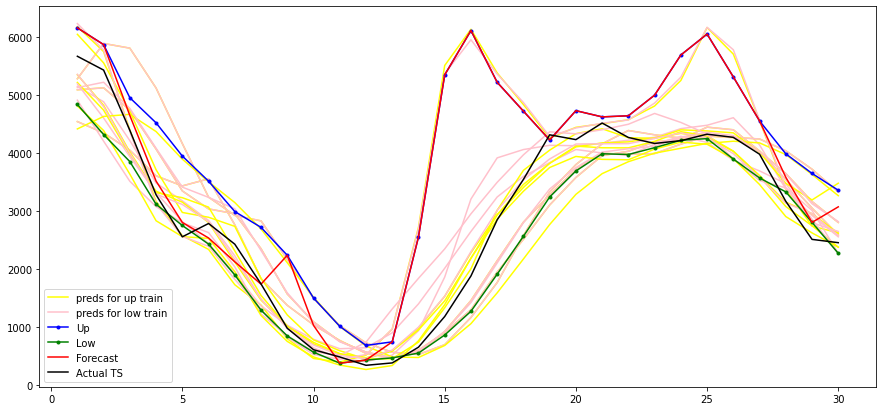

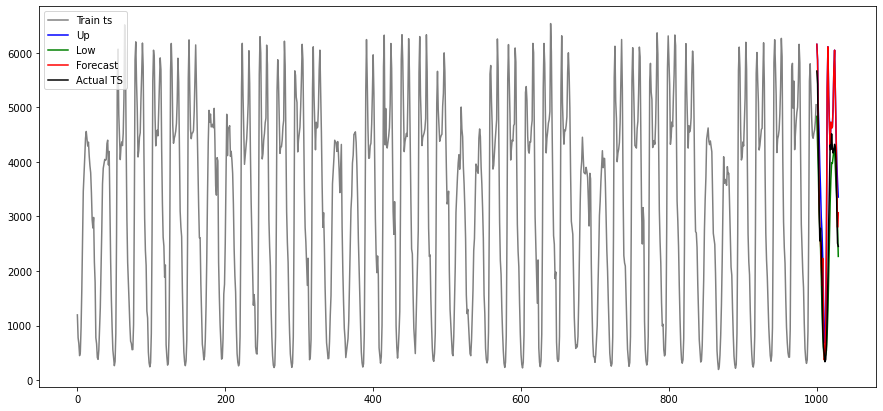

In [33]:
conf_int_plotting(up_predictions = x['up_predictions'],
                  low_predictions = x['low_predictions'],
                  regim='quantile',
                  plot_history = True,
                  plot_up_int = True,
                  plot_low_int = True,
                  plot_trend = False,
                  plot_forecast = True,
                  plot_upper_train = True,
                  plot_lower_train = True,
                  plot_ts_test = True)